<a href="https://colab.research.google.com/github/sakshamio/thinkspace/blob/master/Copy_of_Blackjack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import sys
import gym
import numpy as np
import random
from collections import defaultdict

In [0]:
env = gym.make('Blackjack-v0')

In [0]:
help(env) #this will explain the env

Help on BlackjackEnv in module gym.envs.toy_text.blackjack object:

class BlackjackEnv(gym.core.Env)
 |  Simple blackjack environment
 |  
 |  Blackjack is a card game where the goal is to obtain cards that sum to as
 |  near as possible to 21 without going over.  They're playing against a fixed
 |  dealer.
 |  Face cards (Jack, Queen, King) have point value 10.
 |  Aces can either count as 11 or 1, and it's called 'usable' at 11.
 |  This game is placed with an infinite deck (or with replacement).
 |  The game starts with each (player and dealer) having one face up and one
 |  face down card.
 |  
 |  The player can request additional cards (hit=1) until they decide to stop
 |  (stick=0) or exceed 21 (bust).
 |  
 |  After the player sticks, the dealer reveals their facedown card, and draws
 |  until their sum is 17 or greater.  If the dealer goes bust the player wins.
 |  
 |  If neither player nor dealer busts, the outcome (win, lose, draw) is
 |  decided by whose sum is closer to 2

In [0]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


States:
*  Players current sum: [0,31] i.e. 32 states
*  Dealer's face up card: [1,10] i.e. 10 states
*  Whether the player has a usable ace or not: [0,1] i.e. 2 states

Actions:
* Either stick or hit: [0,1] i.e 0 for stick , 1 for hit

In [0]:
#Random Policy:
for i_episode in range(5):
    state = env.reset()
    while True:
        print(state)
        action = env.action_space.sample() # takes random action from environment's action space
        state, reward, done, info = env.step(action) # OpenAI gym gives feedback in this tuple form : state,reward,if_done?,other relevant info
        if done:
            print('Game has ended! Your Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

(20, 9, False)
Game has ended! Your Reward:  1.0
You won :)

(8, 4, False)
(18, 4, False)
Game has ended! Your Reward:  -1
You lost :(

(14, 10, False)
Game has ended! Your Reward:  -1.0
You lost :(

(18, 9, False)
Game has ended! Your Reward:  -1
You lost :(

(9, 10, False)
(19, 10, False)
Game has ended! Your Reward:  -1
You lost :(



# Monte Carlo Prediction
But we can start with a better policy, ie which sticks with 80% probability if sum is greater than 18 as we don't want to exceed 21. Else if sum is less than 18, we'll hit with 80% probability. Following code generates episodes using the following policy and then later we'll evaluate this policy: (Note here an episode is a list of (state, action, reward) tuples corresponding to every action taken in the episode )

In [0]:
np.arange(2)

array([0, 1])

In [0]:
#Note: The following command will give 0 as output with probability 0.2 whereas 1 as output 0.8 times
np.random.choice([0,1], p=[0.2,0.8])

1

In [0]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset() #here, bj_env is the env instance
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [0]:
for i in range(5):
    print(generate_episode_from_limit_stochastic(env))

[((17, 1, False), 0, -1.0)]
[((9, 5, False), 1, 0), ((18, 5, False), 1, -1)]
[((17, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[((12, 10, False), 1, 0), ((17, 10, False), 0, -1.0)]
[((14, 10, False), 0, -1.0)]


Let's evaluate this policy ourselves, for that we'll use Monte Carlo Prediction.
We can either use first visit or every visit update, but both methods are equivalent in the BlackJack case, so we'll continue with every visit.

In [0]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # Let us monitor our progress :)
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            
            
        # Generating an episode using our 80-20 policy we defined above:
        episode = generate_episode(env)
        # obtain the states, actions, and rewards
        states, actions, rewards = zip(*episode)
        '''
        This discounts array is the amount by which we wanna discount each consequent reward ie.
        discounts = [1,gamma, gamma^2, gamma^3.....] 
        then we compute the total return Gt= Rt+1 *1 + Rt+2 * gamma + Rt+3 * gamma^2 +...
        '''
        discounts = np.array([gamma**i for i in range(len(rewards)+1)]) 
        # update the sum of the returns, number of visits, and action-value 
        # function estimates for each state-action pair in the episode
        for i, state in enumerate(states): #ever-visit
            returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])
            N[state][actions[i]] += 1.0
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
            #Just taking the mean of all the returns got by taking this action when we were in this state.
    return Q

In [0]:
# obtain the action-value function
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)


Episode 500000/500000.

Don't get too involved in the details of the function below, as it used to just plot the State values. The higher the state value, the better it is to be in that state, according to this policy:

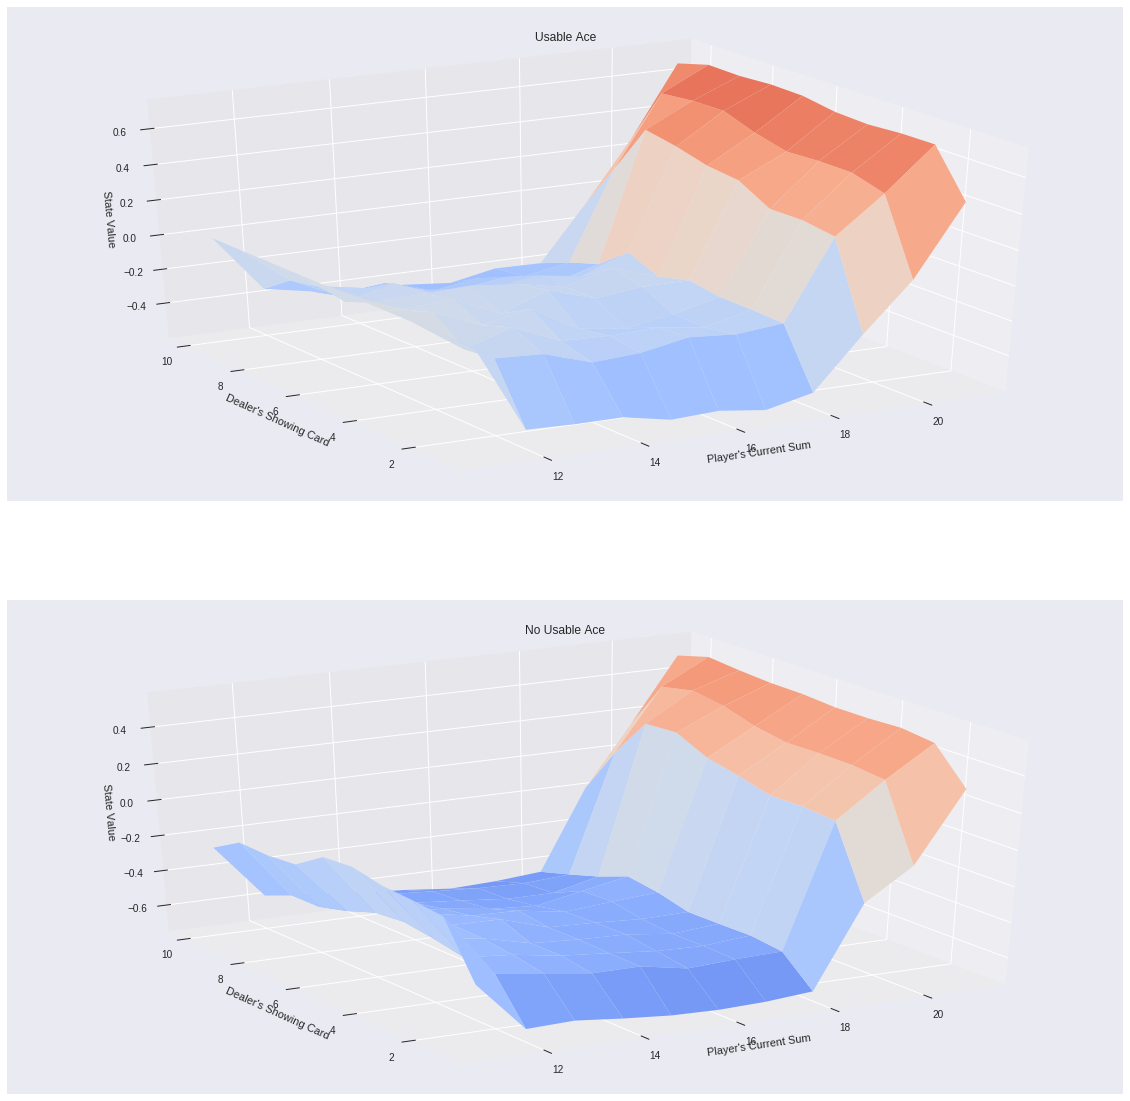

In [0]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_blackjack_values(V):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in V:
            return V[x,y,usable_ace]
        else:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()
    
# obtain the corresponding state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)    

# Monte Carlo Control
By now we have learnt to estimate the action-value function corresponding to any stochastic policy by making the agent use the policy for many episodes using the Monte Carlo Prediction.
Once we have approximately represented our starting stochastic policy using this Q-table, we can improve upon it using Monte Carlo Control. 
* To improve we need to get the new policy which is epsilon greedy wrt old policy. 
* Generate/ play the game using new policy.
* Update the Q-table according to rewards collected from the episodes played using the new policy.

Following 3 functions do exactly the same:

In [0]:
def get_probs(Q_s, epsilon, nA): #nA is no. of actions in the action space
    # obtains the action probabilities corresponding to epsilon-greedy policy
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s
  
''' 
Now we will use this get_probs func in generating the episode. 
Note that we are no longer using the stochastic policy we started with, instead building upon it in an epsilon greedy way.
'''
def generate_episode_from_Q(env, Q, epsilon, nA):
    # generates an episode from following the epsilon-greedy policy
    episode = []
    state = env.reset()
    while True:
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) \
                                    if state in Q else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

''' 
Finally Q values are approximated by taking average of corresponding returns.
But instead we can write it using incremental mean and constant alpha.
As we are using constant alpha we need not keep a track of N-table, ie how many times we visited that state.
''' 

def update_Q(env, episode, Q, alpha, gamma):
    # updates the action-value function estimate using the most recent episode 
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]] 
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    return Q

In [0]:
def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # set the value of epsilon
        epsilon = max(epsilon*eps_decay, eps_min)
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        # update the action-value function estimate using the episode
        Q = update_Q(env, episode, Q, alpha, gamma)
    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q

Episode 500000/500000.

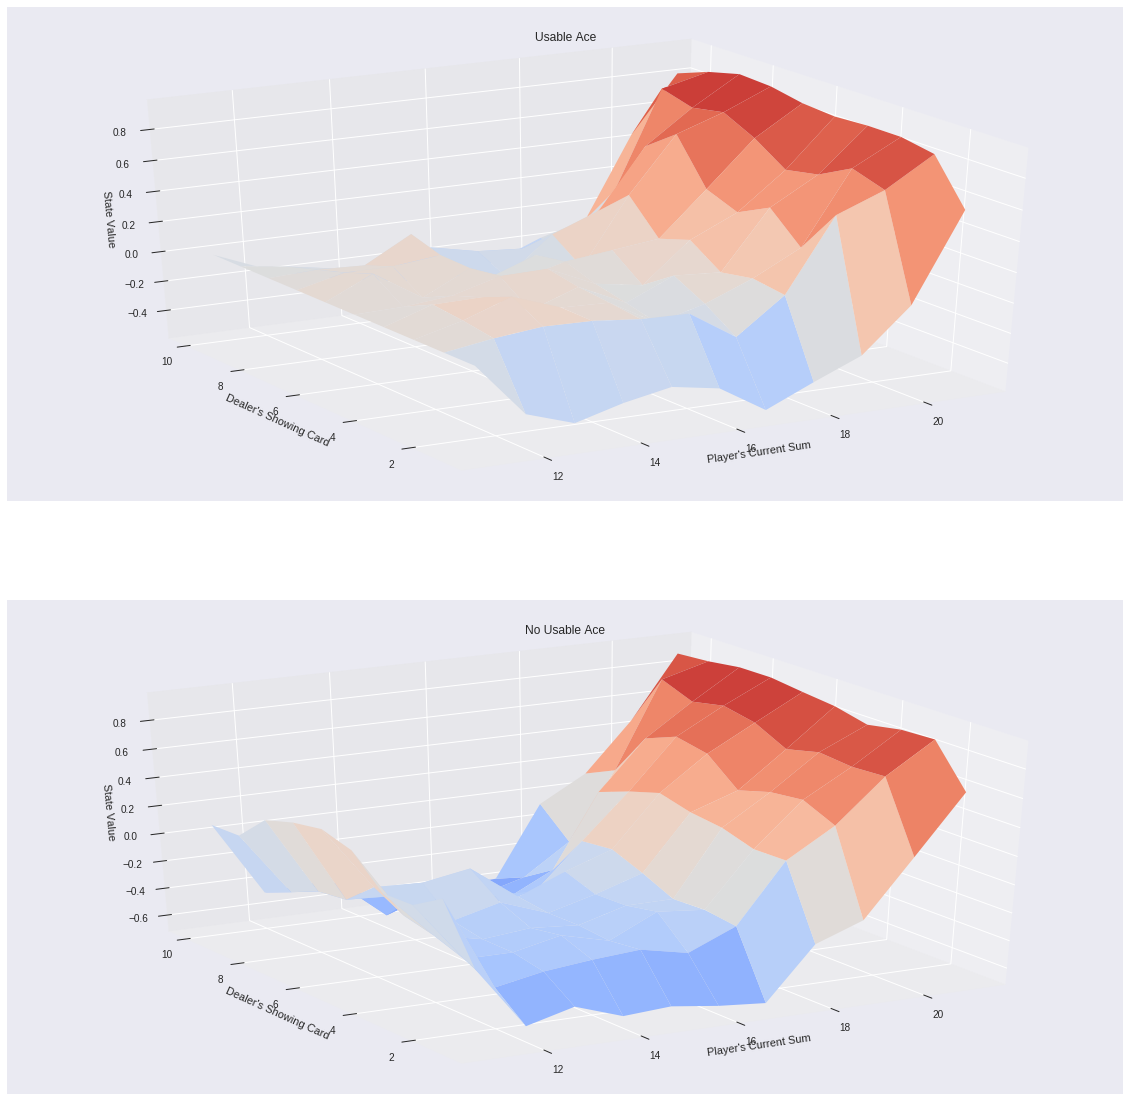

In [0]:
# obtain the estimated optimal policy and action-value function
policy, Q = mc_control(env, 500000, 0.015)

# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

We see that the state-values have considerable changed, let's see the policy learnt:

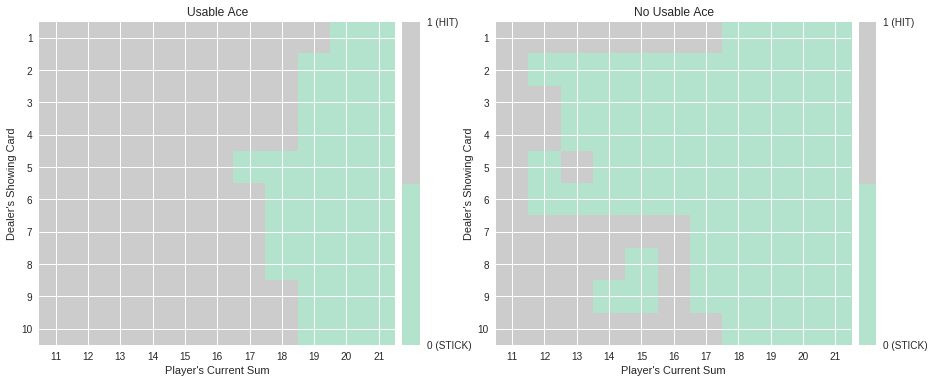

In [0]:
def plot_policy(policy):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in policy:
            return policy[x,y,usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(10, 0, -1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x,y,usable_ace) for x in x_range] for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[10.5, 21.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
            
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

# plot the policy
plot_policy(policy)

True optimal policy $\pi_*$ 
![true optimal policy $\pi_*$ t](https://github.com/udacity/deep-reinforcement-learning/raw/d6cb43c1b11b1d55c13ac86d6002137c7b880c15/monte-carlo/images/optimal.png)

In [0]:
nA=env.action_space.n
for i_episode in range(10):
    state = env.reset()
    while True:
        print(state)
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], 0, nA)) \
                                    if state in Q else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        state = next_state
        if done:
            print('Game has ended! Your Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

(21, 8, True)
Game has ended! Your Reward:  1.0
You won :)

(17, 9, True)
(20, 9, True)
Game has ended! Your Reward:  1.0
You won :)

(12, 5, False)
Game has ended! Your Reward:  -1.0
You lost :(

(17, 10, False)
(20, 10, False)
Game has ended! Your Reward:  1.0
You won :)

(19, 4, False)
Game has ended! Your Reward:  1.0
You won :)

(17, 10, True)
(20, 10, True)
Game has ended! Your Reward:  1.0
You won :)

(20, 7, False)
Game has ended! Your Reward:  1.0
You won :)

(20, 5, False)
Game has ended! Your Reward:  1.0
You won :)

(10, 10, False)
(16, 10, False)
Game has ended! Your Reward:  -1
You lost :(

(18, 6, True)
Game has ended! Your Reward:  1.0
You won :)



#SARSA (Temporal Difference control)

In [0]:
def update_Q_sarsa(alpha, gamma, Q, state, action, reward, next_state=None, next_action=None):
    """Returns updated Q-value for the most recent experience."""
    current = Q[state][action]  # estimate in Q-table (for current state, action pair)
    # get value of state, action pair at next time step
    Qsa_next = Q[next_state][next_action] if next_state is not None else 0    
    target = reward + (gamma * Qsa_next)               # construct TD target
    new_value = current + (alpha * (target - current)) # get updated value
    return new_value

def epsilon_greedy(Q, state, nA, eps):
    """Selects epsilon-greedy action for supplied state.
    
    Params
    ======
        Q (dictionary): action-value function
        state (int): current state
        nA (int): number actions in the environment
        eps (float): epsilon
    """
    if random.random() > eps: # select greedy action with probability epsilon
        return np.argmax(Q[state])
    else:                     # otherwise, select an action randomly
        return random.choice(np.arange(env.action_space.n))

In [0]:
def sarsa(env, num_episodes, alpha, gamma=1.0, epsmin=0.01):
    nA = env.action_space.n                # number of actions
    Q = defaultdict(lambda: np.zeros(nA))  # initialize empty dictionary of arrays
   
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()   
        score = 0                                             # initialize score
        state = env.reset()                                   # start episode
        
        eps = max(1.0 / i_episode, epsmin)                                 # set value of epsilon
        action = epsilon_greedy(Q, state, nA, eps)            # epsilon-greedy action selection
        
        while True:
            next_state, reward, done, info = env.step(action) # take action A, observe R, S'
            score += reward                                   # add reward to agent's score
            if not done:
                next_action = epsilon_greedy(Q, next_state, nA, eps) # epsilon-greedy action
                Q[state][action] = update_Q_sarsa(alpha, gamma, Q, \
                                                  state, action, reward, next_state, next_action)
                
                state = next_state     # S <- S'
                action = next_action   # A <- A'
            if done:
                Q[state][action] = update_Q_sarsa(alpha, gamma, Q, \
                                                  state, action, reward)
                break
                
    return Q


Episode 500000/500000

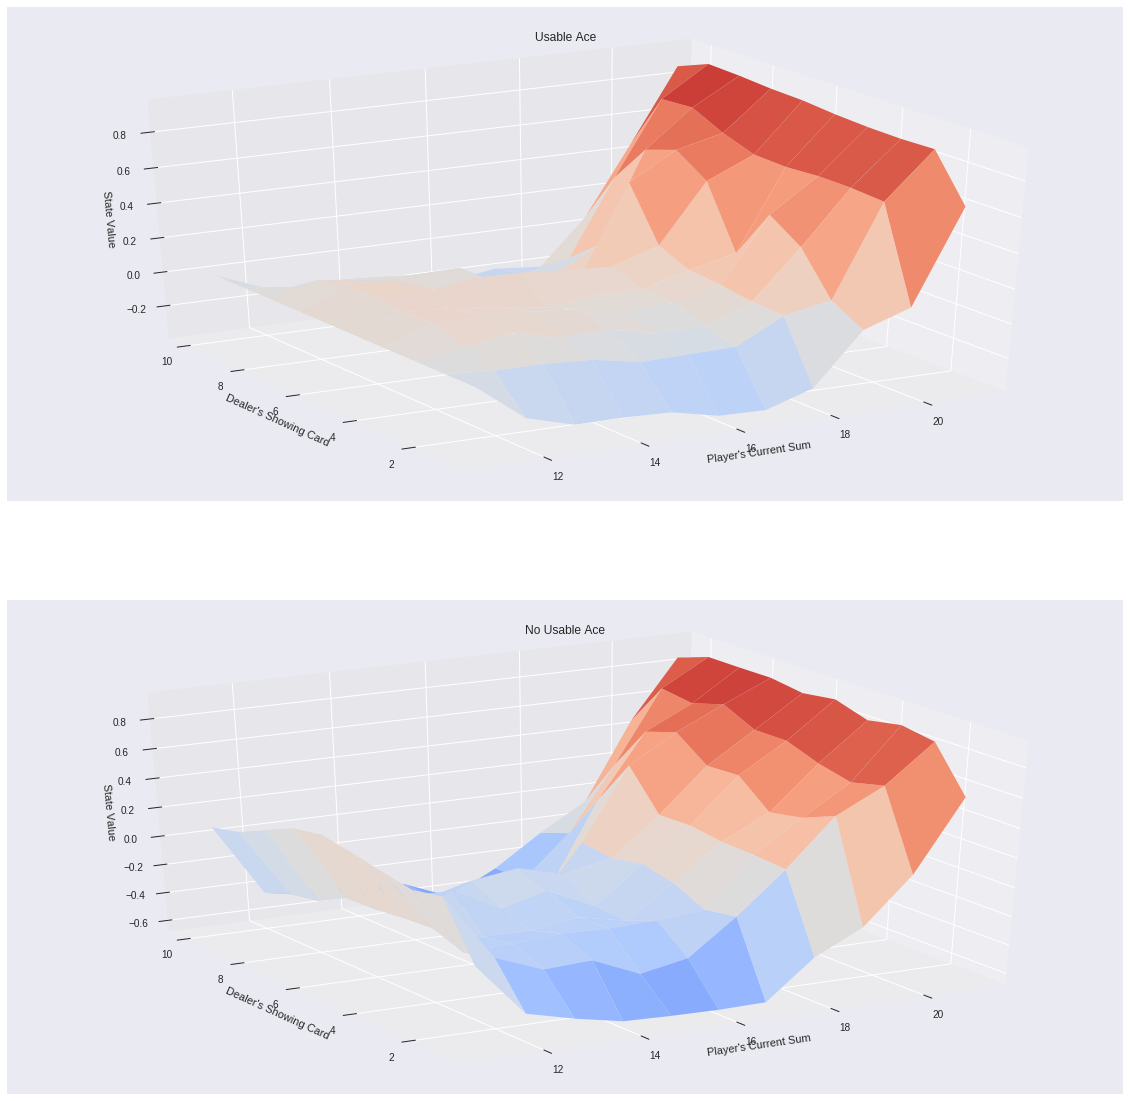

In [0]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsa = sarsa(env, 500000, 0.009)

# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q_sarsa.items())

# plot the state-value function
plot_blackjack_values(V)

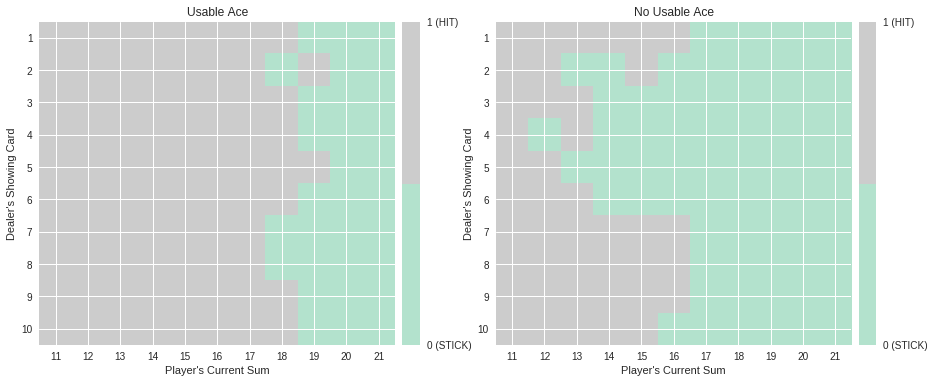

In [0]:
policy_sarsa = dict((k,np.argmax(v)) for k, v in Q_sarsa.items())
# plot the policy
plot_policy(policy_sarsa)

#Q-learning or Sarsamax

In [0]:
def update_Q_sarsamax(alpha, gamma, Q, state, action, reward, next_state=None):
    """Returns updated Q-value for the most recent experience."""
    current = Q[state][action]  # estimate in Q-table (for current state, action pair)
    Qsa_next = np.max(Q[next_state]) if next_state is not None else 0  # value of next state 
    target = reward + (gamma * Qsa_next)               # construct TD target
    new_value = current + (alpha * (target - current)) # get updated value 
    return new_value

In [0]:
def q_learning(env, num_episodes, alpha, gamma=1.0,epsmin=0.01):
    """Q-Learning - TD Control
    
    Params
    ======
        num_episodes (int): number of episodes to run the algorithm
        alpha (float): learning rate
        gamma (float): discount factor
        plot_every (int): number of episodes to use when calculating average score
    """
    nA = env.action_space.n                # number of actions
    Q = defaultdict(lambda: np.zeros(nA))  # initialize empty dictionary of arrays
    
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        score = 0                                              # initialize score
        state = env.reset()                                    # start episode
        eps = max(1.0 / i_episode ,epsmin)                                 # set value of epsilon
        
                
        while True:
            action = epsilon_greedy(Q, state, nA, eps)         # epsilon-greedy action selection
            next_state, reward, done, info = env.step(action)  # take action A, observe R, S'
            score += reward                                    # add reward to agent's score
            Q[state][action] = update_Q_sarsamax(alpha, gamma, Q, \
                                                 state, action, reward, next_state)        
            state = next_state                                 # S <- S'
            # note: no A <- A'
            if done:
                break
    return Q

In [0]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsamax = sarsa(env, 500000, 0.01)

# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q_sarsamax.items())

# plot the state-value function
#plot_blackjack_values(V)

Episode 500000/500000

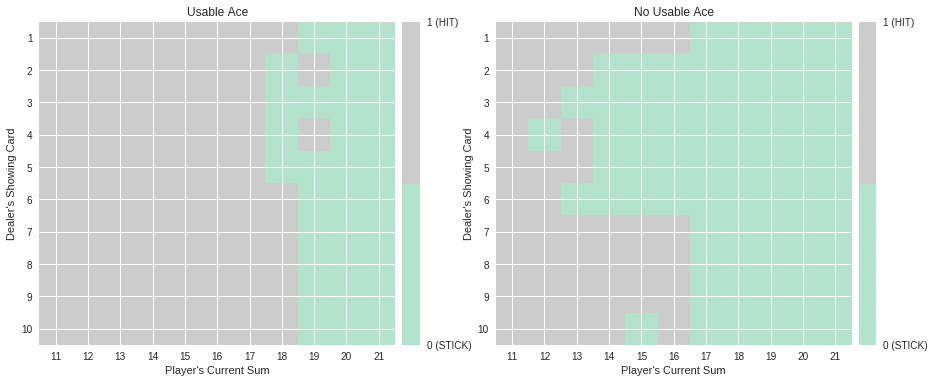

In [0]:
policy_sarsamax = dict((k,np.argmax(v)) for k, v in Q_sarsamax.items())
# plot the policy
plot_policy(policy_sarsamax)

#Expected Sarsa

In [0]:
def update_Q_expsarsa(alpha, gamma, nA, eps, Q, state, action, reward, next_state=None):
    """Returns updated Q-value for the most recent experience."""
    current = Q[state][action]         # estimate in Q-table (for current state, action pair)
    policy_s = np.ones(nA) * eps / nA  # current policy (for next state S')
    policy_s[np.argmax(Q[next_state])] = 1 - eps + (eps / nA) # greedy action
    Qsa_next = np.dot(Q[next_state], policy_s)         # get value of state at next time step
    target = reward + (gamma * Qsa_next)               # construct target
    new_value = current + (alpha * (target - current)) # get updated value 
    return new_value

In [0]:
def sarsa(env, num_episodes, alpha, gamma=1.0, epsmin=0.01):
    nA = env.action_space.n                # number of actions
    Q = defaultdict(lambda: np.zeros(nA))  # initialize empty dictionary of arrays
   
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()   
        score = 0                                             # initialize score
        state = env.reset()                                   # start episode
        
        eps = max(1.0 / i_episode, epsmin)                                 # set value of epsilon
        action = epsilon_greedy(Q, state, nA, eps)            # epsilon-greedy action selection
        
        while True:
            action = epsilon_greedy(Q, state, nA, eps)         # epsilon-greedy action selection
            next_state, reward, done, info = env.step(action)  # take action A, observe R, S'
            score += reward                                    # add reward to agent's score
            # update Q
            Q[state][action] = update_Q_expsarsa(alpha, gamma, nA, eps, Q, \
                                                 state, action, reward, next_state)        
            state = next_state                           # S <- S'
            if done:
                Q[state][action] = update_Q_sarsa(alpha, gamma, Q, \
                                                  state, action, reward)
                break
                
    return Q


In [0]:
# obtain the estimated optimal policy and corresponding action-value function
Q_expsarsa = sarsa(env, 500000, 0.01)

# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q_expsarsa.items())

# plot the state-value function
#plot_blackjack_values(V)

Episode 500000/500000

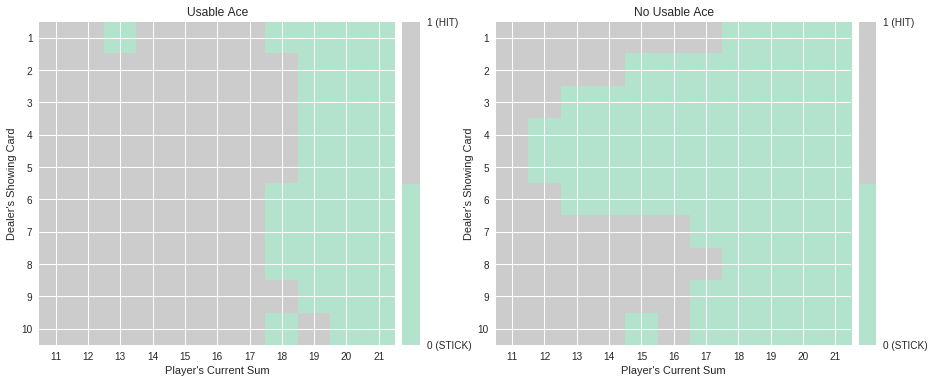

In [0]:
policy_expsarsa = dict((k,np.argmax(v)) for k, v in Q_sarsamax.items())
# plot the policy
plot_policy(policy_expsarsa)